In [1]:
! git clone https://github.com/Bhavay-Garg/Lung-Disease-Detection.git

Cloning into 'Lung-Disease-Detection'...
remote: Enumerating objects: 10118, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10118 (delta 1), reused 10 (delta 1), pack-reused 10108
Receiving objects: 100% (10118/10118), 2.17 GiB | 18.23 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (10101/10101), done.


In [ ]:
!pip install efficientnet_pytorch

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [3]:
class CFG:

  epochs =20                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'tf_efficientnet_b3_ns'    # Model name (we are going to import model from timm)
  img_size = 300                          # Resize all the images to be 300 by 300

  # going to be used for loading dataset
  train_path='/content/Lung-Disease-Detection/Dataset/train'
  validate_path='/content/Lung-Disease-Detection/Dataset/val'
  test_path='/content/Lung-Disease-Detection/Dataset/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [4]:
from torchvision import transforms as T,datasets

In [5]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [ ]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

In [7]:
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  2016


In [8]:
testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

testset Size:  2025


In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:379
No. of Total examples:6054


In [11]:
validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:126
No. of Total examples:2016


In [12]:
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:127
No. of Total examples:2025


In [13]:
!pip install timm # install PyTorch Image Models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.1 MB/s eta 0:00:00


In [15]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [18]:
#let's update the pretarined model:
for param in model.parameters():
  param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1536, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=5), 
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=5, bias=True)
#  )

EfficientNet(
  (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [19]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 40, 112, 112]           1,080
          Identity-2         [-1, 40, 112, 112]               0
              SiLU-3         [-1, 40, 112, 112]               0
    BatchNormAct2d-4         [-1, 40, 112, 112]              80
            Conv2d-5         [-1, 40, 112, 112]             360
          Identity-6         [-1, 40, 112, 112]               0
              SiLU-7         [-1, 40, 112, 112]               0
    BatchNormAct2d-8         [-1, 40, 112, 112]              80
            Conv2d-9             [-1, 10, 1, 1]             410
             SiLU-10             [-1, 10, 1, 1]               0
           Conv2d-11             [-1, 40, 1, 1]             440
          Sigmoid-12             [-1, 40, 1, 1]               0
    SqueezeExcite-13         [-1, 40, 112, 112]               0
           Conv2d-14         [-1, 24, 1

In [22]:
class Trainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
        # Lists to store accuracies and losses
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_loss_history = []
        self.val_loss_history = []
            
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))
            self.train_acc_history.append(avg_train_acc)
            self.val_acc_history.append(avg_valid_acc)
            self.train_loss_history.append(avg_train_loss)
            self.val_loss_history.append(avg_valid_loss)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = Trainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.6599305199961814
Epoch : 1 Train Loss : 0.718659 Train Acc : 0.710972
Epoch : 1 Valid Loss : 0.659931 Valid Acc : 0.730655


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Valid_loss decreased 0.6599305199961814 --> 0.5188468302053119
Epoch : 2 Train Loss : 0.557905 Train Acc : 0.774132
Epoch : 2 Valid Loss : 0.518847 Valid Acc : 0.794147


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Valid_loss decreased 0.5188468302053119 --> 0.4793715708194271
Epoch : 3 Train Loss : 0.520666 Train Acc : 0.786774
Epoch : 3 Valid Loss : 0.479372 Valid Acc : 0.810516


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.485057 Train Acc : 0.806618
Epoch : 4 Valid Loss : 0.549868 Valid Acc : 0.774306


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.465992 Train Acc : 0.810466
Epoch : 5 Valid Loss : 0.523710 Valid Acc : 0.781746


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.440814 Train Acc : 0.824868
Epoch : 6 Valid Loss : 0.508725 Valid Acc : 0.807044


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Valid_loss decreased 0.4793715708194271 --> 0.45372376993062
Epoch : 7 Train Loss : 0.443125 Train Acc : 0.824538
Epoch : 7 Valid Loss : 0.453724 Valid Acc : 0.830357


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.439330 Train Acc : 0.826902
Epoch : 8 Valid Loss : 0.487755 Valid Acc : 0.792659


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.414852 Train Acc : 0.834048
Epoch : 9 Valid Loss : 0.470091 Valid Acc : 0.803571


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.413438 Train Acc : 0.836522
Epoch : 10 Valid Loss : 0.457625 Valid Acc : 0.820437


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Valid_loss decreased 0.45372376993062 --> 0.4383506699805222
Epoch : 11 Train Loss : 0.406750 Train Acc : 0.834103
Epoch : 11 Valid Loss : 0.438351 Valid Acc : 0.820933


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.409202 Train Acc : 0.836632
Epoch : 12 Valid Loss : 0.467307 Valid Acc : 0.809028


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Valid_loss decreased 0.4383506699805222 --> 0.4350869527293576
Epoch : 13 Train Loss : 0.384417 Train Acc : 0.848725
Epoch : 13 Valid Loss : 0.435087 Valid Acc : 0.816964


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.391458 Train Acc : 0.843887
Epoch : 14 Valid Loss : 0.486012 Valid Acc : 0.818948


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.380599 Train Acc : 0.849055
Epoch : 15 Valid Loss : 0.435403 Valid Acc : 0.826389


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Valid_loss decreased 0.4350869527293576 --> 0.4268181703038632
Epoch : 16 Train Loss : 0.381050 Train Acc : 0.846196
Epoch : 16 Valid Loss : 0.426818 Valid Acc : 0.838294


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.381163 Train Acc : 0.853397
Epoch : 17 Valid Loss : 0.463019 Valid Acc : 0.819444


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Valid_loss decreased 0.4268181703038632 --> 0.395677653688287
Epoch : 18 Train Loss : 0.359142 Train Acc : 0.857355
Epoch : 18 Valid Loss : 0.395678 Valid Acc : 0.840774


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.359491 Train Acc : 0.852847
Epoch : 19 Valid Loss : 0.491355 Valid Acc : 0.807540


  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.365074 Train Acc : 0.854387
Epoch : 20 Valid Loss : 0.477077 Valid Acc : 0.817956


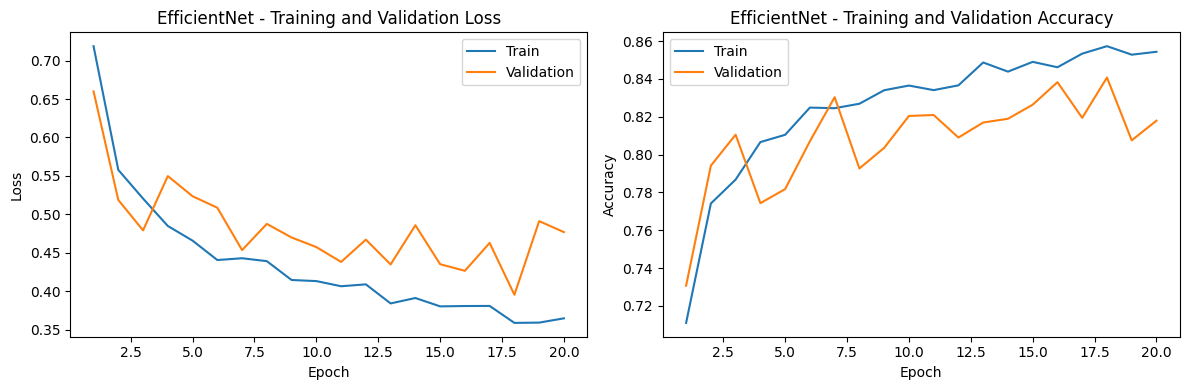

In [26]:
# Move tensors to CPU
train_acc_history = [acc.cpu().numpy() for acc in trainer.train_acc_history]
val_acc_history = [acc.cpu().numpy() for acc in trainer.val_acc_history]

# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 20 + 1), trainer.train_loss_history, label='Train')
plt.plot(range(1, 20 + 1), trainer.val_loss_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('EfficientNet - Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 20 + 1), train_acc_history, label='Train')
plt.plot(range(1, 20 + 1), val_acc_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNet - Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
print(train_acc_history)
print(val_acc_history)
print(trainer.train_loss_history)
print(trainer.val_loss_history)


[array(0.7109719, dtype=float32), array(0.77413154, dtype=float32), array(0.7867744, dtype=float32), array(0.80661833, dtype=float32), array(0.8104661, dtype=float32), array(0.8248681, dtype=float32), array(0.82453823, dtype=float32), array(0.826902, dtype=float32), array(0.8340479, dtype=float32), array(0.8365215, dtype=float32), array(0.8341029, dtype=float32), array(0.83663154, dtype=float32), array(0.84872466, dtype=float32), array(0.84388745, dtype=float32), array(0.8490545, dtype=float32), array(0.8461962, dtype=float32), array(0.8533971, dtype=float32), array(0.8573549, dtype=float32), array(0.8528474, dtype=float32), array(0.85438657, dtype=float32)]
[array(0.7306548, dtype=float32), array(0.79414684, dtype=float32), array(0.8105159, dtype=float32), array(0.7743056, dtype=float32), array(0.78174603, dtype=float32), array(0.8070437, dtype=float32), array(0.83035713, dtype=float32), array(0.79265875, dtype=float32), array(0.8035714, dtype=float32), array(0.82043654, dtype=float32

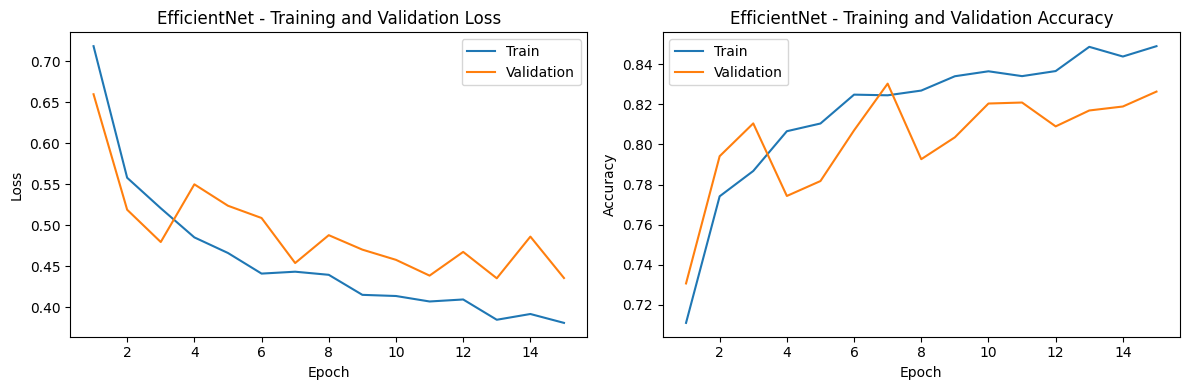

In [30]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 15 + 1), trainer.train_loss_history[:15], label='Train')
plt.plot(range(1, 15 + 1), trainer.val_loss_history[:15], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('EfficientNet - Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 15 + 1), train_acc_history[:15], label='Train')
plt.plot(range(1, 15 + 1), val_acc_history[:15], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNet - Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()